notebook um CNN zu definieren und mit attentionmaps von DINO zu trainieren und zu testen (teilweise auch evaluieren)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!git clone https://github.com/cocodataset/cocoapi

!cd /content/cocoapi/PythonAPI && make

In [ ]:
 !pip install timm
 
 !git clone https://github.com/Moldazien/BA.git

In [ ]:
import os
os.chdir('/content/BA')

In [ ]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

import utils
import vision_transformer as vits

from pycocotools.coco import COCO

In [ ]:
arch = 'vit_base' #'vit_small''vit_base'
patch_size = 8
output_dir = '/content/gdrive/MyDrive/Testing/first_test_dino'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import numpy as np

def crop_fkt(bbox, area, percentile, width, height):
  width = width
  height = height
  width_edge = bbox[2]*percentile
  height_edge = bbox[3]*percentile
  edge = (width_edge + height_edge)
  tx = max(bbox[0]-edge, 0)
  ty = max(bbox[1]-edge, 0)
  bx = min(bbox[0]+bbox[2]+edge, width)
  by = min(bbox[1]+bbox[3]+edge, height)
  area = 80000
  wid = bx - tx
  hei = by - ty
  p = np.sqrt(area/(wid*hei))
  imagewidth = int(wid*p) - (int(wid*p)%8)
  imageheight = int(hei*p) - (int(hei*p)%8)
  img_size = (imageheight, imagewidth)
  return (tx, ty, bx, by), img_size

In [ ]:
def gt_tensors(attentions, maskimg, bbox, width, height):
  percentile = 0 
  patch_size = 8
  image_size = (480, 480)
  area = 60000

  box, img_size = crop_fkt(bbox, area, percentile, width, height)
  crop_mask = maskimg.crop(box=box)
  mask = np.asarray(crop_mask)
  mask = torch.tensor(mask)
  mask = mask.reshape(1, mask.shape[0], mask.shape[1]).float()
  img_size = (285, 285)
  transforms = pth_transforms.Compose([
                                      pth_transforms.Resize(img_size, interpolation = InterpolationMode('nearest')),
                                     ])
  attentions = transforms(attentions)
  mask = transforms(mask)
  return attentions, mask

# custom dataset

In [ ]:
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode

class NACTI_seg(Dataset):
  def __init__(self, annotations_file, dataset_dir, flip):
    self.annotations_file = annotations_file
    self.coco = COCO(annotations_file) 
    self.flip = flip
    self.dataset = dataset_dir
    self.img_ids = self.coco.getImgIds()
    self.ann_ids = self.coco.getAnnIds()

  def __len__(self):
    return len(self.ann_ids)

  def __getitem__(self, idx):
    ann_id = self.ann_ids[idx]
    ann = self.coco.loadAnns([ann_id])
    img_id = ann[0]['image_id']
    img = self.coco.loadImgs([img_id])

    img_path = self.dataset + '/images/' + img[0]['file_name']
    image = None
    mask = None
    bbox = None    
    width = img[0]['width']
    height = img[0]['height']

    attentions_path = self.dataset + '/tensors/' + str(ann_id) + '_attention.pt'
    attentions = torch.load(attentions_path)
    mask = self.coco.annToMask(ann[0]) 
    bbox = ann[0]['bbox']

    maskImg = Image.fromarray(mask)
    attentions, mask = gt_tensors(attentions, maskImg, bbox, width, height)
    attentions = attentions.to(device)
    mask = mask.to(device)

    if self.flip: #bilder horizontal flippen um daten zu augmentieren
      attentions = pth_transforms.functional.hflip(attentions)
      mask = pth_transforms.functional.hflip(mask)
    return attentions, mask, ann[0]

In [ ]:
class ConcatSet(Dataset):
  def __init__(self, dataset1, dataset2):
    self.dataset1 = dataset1
    self.dataset2 = dataset2
    self.len1 = dataset1.__len__()
    self.len2 = dataset2.__len__()

  def __len__(self):
    return (self.len1 + self.len2)

  def __getitem__(self, idx):
    attentions = None
    mask = None
    if idx < self.len1:
      attentions, mask, ann = self.dataset1.__getitem__(idx)
    elif idx >= self.len1:
      attentions, mask, ann = self.dataset2.__getitem__(idx-self.len1)
    return attentions, mask

In [ ]:
#trainset1 = NACTI_seg('PATH_TO_ANNOTATION', 'PATH_TO_IMAGES', True) #datensatz mit geflippten bildern und masken
#trainset2 = NACTI_seg('PATH_TO_ANNOTATION', 'PATH_TO_IMAGES', False) #datensatz mit normalen bildern mit masken

#trainset =  ConcatSet(trainset1, trainset2)#datensätze zu einem zusammenfügen

Netzwerke, fehlende schichten einfügen

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class SimpleCNN(nn.Module):

    def __init__(self):
      super(SimpleCNN, self).__init__()

      self.conv1 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      #self.conv11 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv3 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv4 = nn.Conv2d(in_channels=12, out_channels=1, kernel_size=1, stride=1, padding=0, padding_mode='reflect')


    def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)
      #x = F.relu(self.conv11(x))
      x = self.conv2(x)
      x = F.relu(x)
      x = self.conv3(x)
      x = F.relu(x)
      x = self.conv4(x)
      return x

In [ ]:
class UCNN(nn.Module):

    def __init__(self):
      super(UCNN, self).__init__()

      self.conv1 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv3 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv4 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv5 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv6 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv7 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv8 = nn.Conv2d(in_channels=12, out_channels=1, kernel_size=3, stride=1, padding=1, padding_mode='reflect')


    def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = F.relu(x)
      x = self.conv3(x)
      x = F.relu(x)
      x = self.conv4(x)
      x = F.relu(x)
      x = self.conv5(x)
      x = F.relu(x)
      x = self.conv6(x)
      x = F.relu(x)
      x = self.conv7(x)
      x = F.relu(x)
      x = self.conv8(x)
      return x

In [ ]:
class HugePlus(nn.Module):

    def __init__(self):
      super(HugePlus, self).__init__()

      self.conv1 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv11 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      #self.conv21 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv3 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv4 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      #self.conv41 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv42 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv5 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv6 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv7 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
      self.conv8 = nn.Conv2d(in_channels=12, out_channels=1, kernel_size=3, stride=1, padding=1, padding_mode='reflect')


    def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)
      x = self.conv11(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = F.relu(x)
      #x = self.conv21(x)
      #x = F.relu(x)
      x = self.conv3(x)
      x = F.relu(x)
      x = self.conv4(x)
      x = F.relu(x)
      #x = self.conv41(x)
      #x = F.relu(x)
      x = self.conv42(x)
      x = F.relu(x)
      x = self.conv5(x)
      x = F.relu(x)
      x = self.conv6(x)
      x = F.relu(x)
      x = self.conv7(x)
      x = F.relu(x)
      x = self.conv8(x)
      return x

# for training

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
trainset1 = NACTI_seg('PATH_TO_ANNOTATION', 'PATH_TO_IMAGES', True) #datensatz mit geflippten bildern und masken
trainset2 = NACTI_seg('PATH_TO_ANNOTATION', 'PATH_TO_IMAGES', False) #datensatz mit normalen bildern mit masken
trainset =  ConcatSet(trainset1, trainset2)

batch_size = 8 # 4 # 16 # 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

In [ ]:
net = UCNN()

net.to(device)

#PATH = 'MODEL_PATH'
#net.load_state_dict(torch.load(PATH))
net.train()

In [ ]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(net.parameters(), lr = 0.0001)  #für verschiedene lerningrates neues training starten

In [ ]:
loss_graph = []

for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, mask = data
        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        output_value = 50
        if i % output_value == output_value - 1:    # print every 2000 mini-batches
          print('[%d, %5d] loss: %.20f' %
              (epoch + 1, i + 1, running_loss / output_value))
          
          loss_graph.append(running_loss / output_value)

          running_loss = 0.0
          #PATH = '/content/gdrive/MyDrive/models/channelislands/CNN' + str(i) + 'modelCNN.pth' #entfernt weil es sonst zu langsam ist
          #torch.save(net.state_dict(), PATH)

print('Finished Training')

PATH = 'MODEL_SAVE'
torch.save(net.state_dict(), PATH)

In [ ]:
import matplotlib.pyplot as plt #loss printen
y_values = np.asarray(loss_graph)
x_values = np.arange(0,len(y_values),1)

plt.plot(x_values, y_values)
plt.ylabel('Loss')

plt.show()

In [ ]:
drive.flush_and_unmount()
drive.mount('/content/gdrive')

# testing

In [ ]:
from __future__ import division
from __future__ import print_function

import os
import cv2
import json, yaml
import numpy as np
from PIL import Image
from collections import OrderedDict
from pycocotools import mask as cocomask
from pycocotools import coco as cocoapi

def __get_annotation__(mask, image=None): #übersetzten einer binären maske in coco format um in json speichern zu können
  labelMask = np.expand_dims(mask, axis=2)
  labelMask = labelMask.astype('uint8')
  labelMask = np.asfortranarray(labelMask)
  Rs = cocomask.encode(labelMask)
  assert len(Rs) == 1
  Rs = Rs[0]
  area = cocomask.area(Rs)
  return Rs, area 

In [ ]:
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode

class TestSet(Dataset):
  def __init__(self, annotations_file, dataset_dir, flip):
    self.annotations_file = annotations_file
    self.coco = COCO(annotations_file)  #for fast reading
    self.flip = flip
    self.dataset = dataset_dir
    self.img_ids = self.coco.getImgIds()
    self.ann_ids = self.coco.getAnnIds()

  def __len__(self):
    return len(self.ann_ids)

  def __getitem__(self, idx):
    ann_id = self.ann_ids[idx]
    ann = self.coco.loadAnns([ann_id])
    img_id = ann[0]['image_id']
    img = self.coco.loadImgs([img_id])
    img_path = self.dataset + '/images/' + img[0]['file_name']
    image = None
    mask = None
    bbox = None#
    
    width = img[0]['width']
    height = img[0]['height']
    attentions_path = self.dataset + '/tensors/' + str(ann_id) + '_attention.pt'
    attentions = torch.load(attentions_path)
    mask = self.coco.annToMask(ann[0])
    #mask = np.zeros((3000,3000))  #falls keine maske vorhanden 
    bbox = ann[0]['bbox']
    maskImg = Image.fromarray(mask)
    attentions = attentions.to(device)
    return attentions, mask, ann[0], bbox, (height, width)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

testset = TestSet('/content/gdrive/MyDrive/Datasets/channelisland_test/annotations/annotations.json', '/content/gdrive/MyDrive/Datasets/channelisland_test', False) 

In [ ]:
PATH = 'MODEL_PATH.pth'

net = UCNN()
net.to(device)
net.load_state_dict(torch.load(PATH))
net.eval()

In [ ]:
test_ids = np.arange(0,testset.__len__(),1)

# for per class evaluation
#Ygt = []
#Ypred = []
#foxgt = []
#fox = []
#skunkgt = []
#skunk = []
#rodentgt = []
#rodent = []
#birdgt = []
#bird = []


pred_anns = []

net.eval()

for i in test_ids:
  print(str(i) + ' von ' + str(len(test_ids)))
  attentions, gtmask, annotation, bbox, dimensions = testset.__getitem__(i)
  Ygt.append(gtmask)
  output = net(attentions.reshape(1,12,attentions.shape[1],attentions.shape[2]))
  transforms = pth_transforms.Compose([
                                      pth_transforms.Resize((int(bbox[3]), int(bbox[2])), interpolation = InterpolationMode('nearest'))
                                     ])
  output = transforms(output)
  output = output.reshape(output.shape[2],output.shape[3])
  m = nn.Sigmoid()

  output = output.detach()
  output = output.to('cpu')
  output = np.asarray(output, dtype=np.float32)

  mask_part = np.copy(output)
  mask_part[mask_part >= 0.5] = 1
  mask_part[mask_part < 0.5] = 0
  pred_mask = np.zeros(dimensions, dtype=np.int8)

  for i in range(mask_part.shape[0]):
    for j in range(mask_part.shape[1]):
      pred_mask[int(bbox[1]) + i, int(bbox[0]) + j] = mask_part[i, j]

  seg, area = __get_annotation__(pred_mask)

  annotation['pred_seg'] = seg
  annotation['pred_seg']['counts'] = annotation['pred_seg']['counts'].decode()
  annotation['pred_area'] = int(area)

  pred_anns.append(annotation)
  Ypred.append(pred_mask)
  ############################### für meanIoU pro klasse
  if annotation['category_id'] == 1:
    foxgt.append(gtmask)
    fox.append(pred_mask)
  if annotation['category_id'] == 2:
    skunkgt.append(gtmask)
    skunk.append(pred_mask)
  if annotation['category_id'] == 3:
    rodentgt.append(gtmask)
    rodent.append(pred_mask)
  if annotation['category_id'] == 4:
    birdgt.append(gtmask)
    bird.append(pred_mask)

In [ ]:
import matplotlib.pyplot as plt #visueller vergleich der berechneten masken mit ground truth masken
import matplotlib.image as mpimg

for i in range(len(Ypred)-220):
  gt_mask = np.copy(Ygt[i])
  pred_mask = np.copy(Ypred[i])

  gt_mask[gt_mask == 1] = 255
  pred_mask[pred_mask == 1] = 255

  imgplot = plt.imshow(gt_mask)
  plt.show()
  imgplot2  = plt.imshow(pred_mask)
  plt.show()

In [ ]:
#berechnen der metriken pro maske
from sklearn.metrics import jaccard_score as IoU
from sklearn.metrics import accuracy_score

iouscores = []
accscores = []

tempgt = birdgt #rodentgt #skunkgt #foxgt #Ygt
temp = bird #rodent #skunk #fox #Ypred

for i in range(len(tempgt)):
  gt = np.copy(tempgt[i])
  pred = np.copy(temp[i])

  iou = IoU(gt, pred, average='micro')

  acc = accuracy_score(gt, pred)

  accscores.append(acc)
  iouscores.append(iou)

In [ ]:
summ = 0

for i in range(len(iouscores)):
  summ = summ + iouscores[i]
print(summ)
summ = summ/len(iouscores)

print(summ) #meanIoU

In [ ]:
summ = 0

for i in range(len(accscores)):
  summ = summ + accscores[i]
print(summ)
summ = summ/len(accscores)

print(summ) meanPixelaccuracy

In [ ]:
import json 

output_file = 'RESULT_FILE.json'

with open(output_file, 'w') as file:
  json.dump(pred_anns, file, indent = 4, sort_keys=False)

** weitere ausgaben zum vergleichen der verschiedenen ansichten (Attention, ausgabeschicht des CNN, Maske,...)**

In [ ]:
attentions, org_mask = testset.__getitem__(23)
attentions = attentions.reshape(-1,attentions.shape[0],attentions.shape[1],attentions.shape[2])

print(attentions.shape)

output = net(attentions)

output = output.reshape(output.shape[2],output.shape[3])

m = nn.Sigmoid()

output = m(output)

org_mas = org_mask.detach().cpu()
org_mas = np.asarray(org_mas)
mask = output.detach().cpu()


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

trans = pth_transforms.ToPILImage()
img = trans(mask)


org_mask1 = org_mask.reshape(org_mask.shape[1], org_mask.shape[2])
org_mask1[org_mask1 == 1] = 255
org_mask1 = org_mask1.cpu()
org_mask1 = np.asarray(org_mask1)
org = Image.fromarray(org_mask1)

imgplot2  = plt.imshow(org)
plt.show()
imgplot = plt.imshow(img)
plt.show()

test = output.detach().cpu()
mask = np.asarray(test)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


mask[mask >= 0.8] = 255
mask[mask < 0.8] = 0

img = Image.fromarray(mask)

org_mask1 = org_mask.reshape(org_mask.shape[1], org_mask.shape[2])

org_mask1[org_mask1 == 1] = 255

org_mask1 = org_mask1.cpu()

org_mask1 = np.asarray(org_mask1)

org = Image.fromarray(org_mask1)

imgplot = plt.imshow(img)
plt.show()
imgplot2  = plt.imshow(org)
plt.show()

In [ ]:
mask = np.asarray(test)

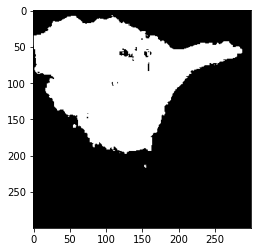

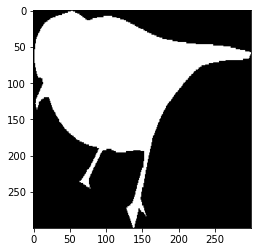

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

mask[mask >= 0.8] = 255
mask[mask < 0.8] = 0

img = Image.fromarray(mask)

org_mask1 = org_mask.reshape(org_mask.shape[1], org_mask.shape[2])

org_mask1[org_mask1 == 1] = 255

org_mask1 = org_mask1.cpu()

org_mask1 = np.asarray(org_mask1)

org = Image.fromarray(org_mask1)

imgplot = plt.imshow(img)
plt.show()
imgplot2  = plt.imshow(org)
plt.show()